## 线性回归
**时间：**2020.02.12 晴天

## 线性回归原理

In [1]:
import torch as t
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

### 数据处理 

In [2]:
feature = 2
samples = 1000

# 设置参数
true_w = [2, -3.4]
true_b = 4.2

# 生成数据
data = t.randn(samples, feature, dtype=t.float32)
labels = true_w[0] * data[:, 0] + true_w[1] * data[:, 1] + true_b

# 数据添加噪声
labels += t.tensor(np.random.normal(0, 0.01, size = labels.size()), dtype=t.float32)

### 数据显示

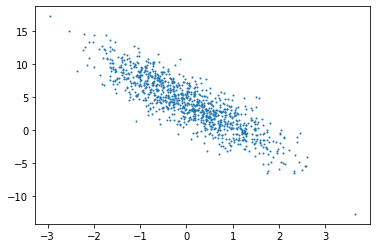

In [3]:
# 只显示了一个维度的数据
plt.scatter(data.numpy()[:, 1], labels.numpy(), s=1)
plt.show()


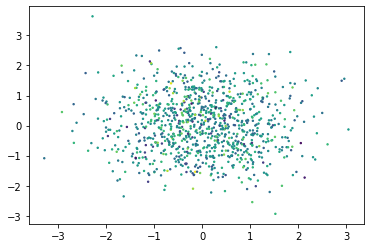

In [25]:
# 只显示了一个维度的数据
plt.scatter(data.numpy()[:, 0], data.numpy()[:, 1],c=labels.numpy(), s=)
plt.show()

In [4]:
def data_iter(batch_size, features, labels):
    """数据的读取"""
    num_examples = len(features)
    indices = list(range(num_examples))
    # 打乱数据
    random.shuffle(indices)
    
    for i in range(0, num_examples, batch_size):
        # 取出索引值
        j = t.LongTensor(indices[i:min(i + batch_size, num_examples)])
        
        yield features.index_select(0, j), labels.index_select(0, j)

In [5]:
batch_size = 10
for X, y in data_iter(batch_size=batch_size, features=data, labels=labels):
    print(X, y)
    break

tensor([[-1.2048, -1.5097],
        [ 1.0234,  1.1029],
        [ 1.7102, -1.0607],
        [-0.6439,  1.4067],
        [-0.8521, -1.6581],
        [-0.3964,  0.3379],
        [-0.4521,  0.1368],
        [ 0.2035, -1.3664],
        [ 1.6812,  1.2832],
        [-0.6727,  1.2427]]) tensor([ 6.9175,  2.5111, 11.2127, -1.8793,  8.1446,  2.2575,  2.8370,  9.2713,
         3.1934, -1.3713])


### 参数初始化 

In [6]:
w = t.tensor(np.random.normal(0, 0.01, (feature, 1)), dtype=t.float32)
b = t.zeros(1, dtype=t.float32)

w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

### 定义模型和损失函数

In [7]:
def linreg(X, w, b):
    """线性回归模型"""
    return t.mm(X, w) + b

def squared_loss(y_hat, y):
    """均方误差损失"""
    return ((y_hat - y.view(y_hat.size())) **2)/ 2

def sgd(params, lr, batch_size):
    """
    优化函数（小批量的梯度下降）
    小批量的是计算一个batch中所有数据的Loss,再对一个batch的梯度进行平均
    """
    for param in params:
        param.data -= param.grad * lr / batch_size        

In [8]:
(squared_loss(t.tensor([2.33, 1.07, 1.23]), t.tensor([3.14, 0.98, 1.32])).sum()/3).item()

0.11205005645751953

### 训练

In [9]:
# 定义超参数

lr = 0.03

num_epochs = 5

net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    
    for X, y in data_iter(batch_size=batch_size, features=data, labels=labels):
        
        l = loss(net(X, w, b), y).sum()
        # BP
        l.backward()
        # 更新参数
        sgd([w, b], lr, batch_size=batch_size)
        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(data, w, b), labels)
    print("epoch % d, loss %f"%(epoch+1, train_l.mean().item()))

epoch  1, loss 0.047203
epoch  2, loss 0.000203
epoch  3, loss 0.000056
epoch  4, loss 0.000055
epoch  5, loss 0.000055


## 使用pytorch简洁使用网络

In [10]:
import torch
from torch import nn
import numpy as np
import torch.utils.data as Data
# 使得模型的可复现性
torch.manual_seed(1)
# 设置默认的数据格式
torch.set_default_tensor_type('torch.FloatTensor')

### 生成数据

In [11]:
num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

### 读取数据 

In [12]:
batch_size = 10

dataset = Data.TensorDataset(features, labels)
# 查看数据的存储类型 [*dataset]
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
for X, y in data_iter:
    print(X, y)
    break

tensor([[-1.7823, -0.3072],
        [ 0.6233,  0.2494],
        [ 1.9436, -0.1446],
        [-0.1384, -0.4158],
        [-0.6803, -0.6537],
        [-1.5873, -1.4596],
        [ 0.1464, -1.9886],
        [ 0.1337,  0.2672],
        [ 1.2284,  0.4943],
        [ 0.6870,  2.8678]]) tensor([ 1.6695,  4.6040,  8.5917,  5.3310,  5.0544,  5.9971, 11.2616,  3.5641,
         4.9635, -4.1558])


### 定义网络

In [13]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    
    def forward(self, x):
        return self.linear(x)
net = LinearNet(feature)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


### 初始化参数模型

In [14]:
from torch.nn import init
for name, param in net.named_parameters():
    if name == "linear.weight":
        init.normal_(param, mean=0.0, std=0.01)
    else:
        init.constant_(param, val=0.0)

In [15]:
# 查看初始化的参数
[*net.parameters()]

[Parameter containing:
 tensor([[ 0.0125, -0.0187]], requires_grad=True), Parameter containing:
 tensor([0.], requires_grad=True)]

### 训练

In [16]:
# 超参数
lr = 0.01
batch_size = 10
num_epochs = 5
# 定义损失
critrion = nn.MSELoss()
# 定义优化函数
optimizer = t.optim.SGD(net.parameters(), lr=lr)

for epoch in range(num_epochs):
    for X, y in data_iter:
        out = net(X)
        loss = critrion(out, y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("epcoch:%d, loss:%f"%(epoch, loss.item()))


epcoch:0, loss:0.861575
epcoch:1, loss:0.015179
epcoch:2, loss:0.000336
epcoch:3, loss:0.000168
epcoch:4, loss:0.000151


In [17]:
#查看训练参数
for name, param in net.named_parameters():
    print(name, param)

linear.weight Parameter containing:
tensor([[ 2.0004, -3.3998]], requires_grad=True)
linear.bias Parameter containing:
tensor([4.1997], requires_grad=True)
